In [3]:
# Libraries
import pandas as pd 
import geojsonio
import numpy as np
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import shapely
from shapely.geometry import shape, Point
from pyproj import Proj, transform
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'geopandas'

# Import results data file

In [4]:
!pip install geopandas

     |████████████████████████████████| 921kB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 1.6MB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 13.4MB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 17.9MB 5.0MB/s eta 0:00:01


In [2]:
results = pd.read_csv('mayoral.csv')
results.head()

,Borough,Turnout2012,LAB2012,CON2012,Turnout2016,LAB2016,CON2016
0,Barking & Dagenham,46135,22718,10410,39307,20965,12006
1,Barnet,114626,39109,54580,105544,32051,57655
2,Bexley,75537,19383,36923,67804,17594,39040
3,Brent,92197,45623,26895,75883,39629,23855
4,Bromley,116007,28751,60510,102810,19926,65904


# Calculate "deltas" (percent) to display the variation

In [3]:
results['LABdeltaPC'] = (results['LAB2016']/results['Turnout2016'] - results['LAB2012']/results['Turnout2012']) * 100
results['CONdeltaPC'] = (results['CON2016']/results['Turnout2016'] - results['CON2012']/results['Turnout2012']) * 100
results.head()

,Borough,Turnout2012,LAB2012,CON2012,Turnout2016,LAB2016,CON2016,LABdeltaPC,CONdeltaPC
0,Barking & Dagenham,46135,22718,10410,39307,20965,12006,4.094115,7.979964
1,Barnet,114626,39109,54580,105544,32051,57655,-3.751357,7.010782
2,Bexley,75537,19383,36923,67804,17594,39040,0.288049,8.697043
3,Brent,92197,45623,26895,75883,39629,23855,2.739562,2.265322
4,Bromley,116007,28751,60510,102810,19926,65904,-5.402466,11.942068


# Import the map and plot it

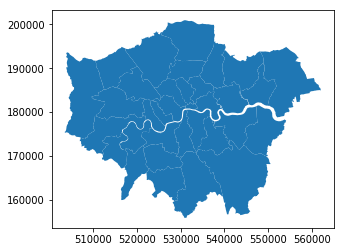

In [4]:
# Assumption: you have a map in geojson format
# If you have a shapefile, you can convert it, e.g.
# ogr2ogr -f GeoJSON countries.json ne_10m_admin_0_countries_lakes.shp
# (http://www.tnoda.com/blog/2013-12-07)
# Other useful tips:
# https://gis.stackexchange.com/questions/78838/converting-projected-coordinates-to-lat-lon-using-python
# https://stackoverflow.com/questions/39620105/converting-between-projections-using-pyproj-in-pandas-dataframe
# https://github.com/geohackweek/tutorial_contents/blob/master/vector/notebooks/geopandas_intro.ipynb

mapdf = gpd.read_file('maps/councils.json')
mapdf.plot() # If this has worked, it should draw a map of london!

# See what a geographical data frame looks like

In [5]:
mapdf.head()
# You should see a number of parameters; what matters is the presence of a unique value (GSS_CODE, but also NAME in this case)
# and a column called "geometry", that contains the councils polygons
# We'll need to match councils['NAME'] with results['Borough'] - but we'll see that in a minute.

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,,,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Croydon,E09000008,8649.441,0.000,F,,,"POLYGON ((535009.2 159504.7, 535005.5 159502, ..."
2,Bromley,E09000006,15013.487,0.000,F,,,"POLYGON ((540373.6 157530.4, 540361.2 157551.9..."
3,Hounslow,E09000018,5658.541,60.755,F,,,"POLYGON ((521975.8 178100, 521967.7 178096.8, ..."
4,Ealing,E09000009,5554.428,0.000,F,,,"POLYGON ((510253.5 182881.6, 510249.9 182886, ..."


# We want to position the triangle around the centroid of each council polygon, so we add longitude and latitude of each centroid 

In [6]:
# Add lon/lat of centroid to our polygons 
data = dict()
data['name'] = []
data['lat'] = []
data['lon'] = []
i = 0

# We iterate over each geometry
for geom in mapdf['geometry']:
    # calculate the centroid coordinates
    centroid = shape(geom).centroid.coords
    # centroid = shape(geom).centroid.wkt
    lon = centroid[0][0] 
    lat = centroid[0][1]
    # data['name'].append(i)
    data['lon'].append(lon)
    data['lat'].append(lat)
    
mapdf['lon'] = data['lon']
mapdf['lat'] = data['lat']

mapdf.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,lon,lat
0,Kingston upon Thames,E09000021,3726.117,0.000,F,,,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",519297.634807,166820.011490
1,Croydon,E09000008,8649.441,0.000,F,,,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",533290.153919,163541.243574
2,Bromley,E09000006,15013.487,0.000,F,,,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",542895.511607,165655.521340
3,Hounslow,E09000018,5658.541,60.755,F,,,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",513515.505536,175643.224320
4,Ealing,E09000009,5554.428,0.000,F,,,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",515887.937770,181715.495617


# The two data frames use the same unique names for councils, so we can merge them into one by using the column NAME on mapdf and Borough on results

In [7]:
# Merge the wards dataset with the results dataset for ease
df = pd.merge(mapdf, results, how = 'left', left_on = 'NAME', right_on = 'Borough')
df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,lon,lat,Borough,Turnout2012,LAB2012,CON2012,Turnout2016,LAB2016,CON2016,LABdeltaPC,CONdeltaPC
0,Kingston upon Thames,E09000021,3726.117,0.000,F,,,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",519297.634807,166820.011490,Kingston upon Thames,59422.0,17174.0,27609.0,48024.0,11963.0,25849.0,-3.991292,7.362581
1,Croydon,E09000008,8649.441,0.000,F,,,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",533290.153919,163541.243574,Croydon,116696.0,46048.0,46794.0,100173.0,37300.0,46997.0,-2.224211,6.816775
2,Bromley,E09000006,15013.487,0.000,F,,,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",542895.511607,165655.521340,Bromley,116007.0,28751.0,60510.0,102810.0,19926.0,65904.0,-5.402466,11.942068
3,Hounslow,E09000018,5658.541,60.755,F,,,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",513515.505536,175643.224320,Hounslow,78754.0,33277.0,27779.0,62516.0,26403.0,26247.0,-0.020374,6.711323
4,Ealing,E09000009,5554.428,0.000,F,,,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",515887.937770,181715.495617,Ealing,116300.0,53907.0,35609.0,93123.0,41217.0,36291.0,-2.090860,8.352810


# Time to draw our triangles. In a few steps:
### - we set the size of the triangles (you will need to play around with these)
### - we calculate the base vertex to be around the centroid
### - we calculate the height
### - we calculate each edge, to be drawn as a 'patch'

In [9]:
# Which variable are we drawing, and which colour we want it to be
TRIANGLE_COLOUR = 'blue' 
COLUMN_NAME = 'CONdeltaPC'

# Settings
HALF_BASE = 250
HEIGHT_MULTIPLIER = 500
POLYGON_FILL_COLOUR = 'white'
POLYGON_EDGE_COLOUR = 'darkgrey'

# Calculate vertex of the triangles
df['triangleL'] = df['lon'] - HALF_BASE
df['triangleR'] = df['lon'] + HALF_BASE
df['triangleH'] = df['lat'] + HEIGHT_MULTIPLIER * df[COLUMN_NAME]

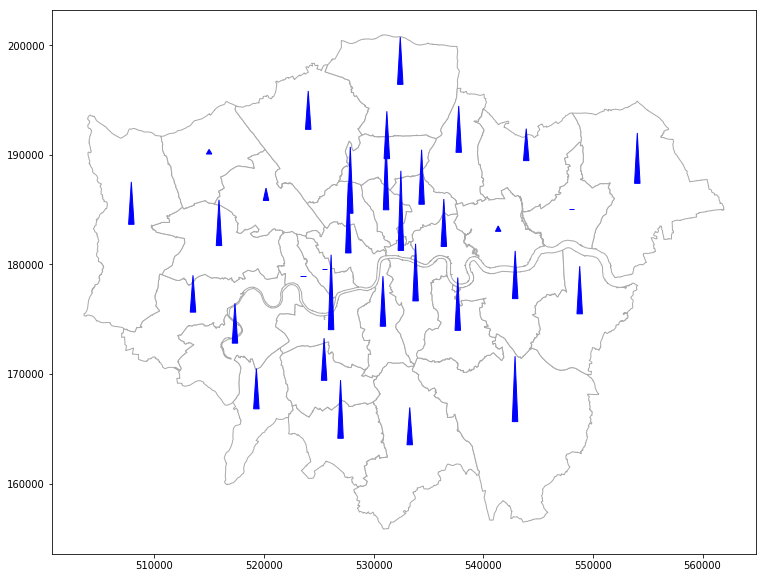

In [13]:
# Using the vertex, calculate the edges
pointsX = []
pointsY = []
# patches are basically the edges 
patches = []


# calculate triangles and turn them into patches
for index, row in df.iterrows():
    L = row['triangleL']
    R = row['triangleR']
    H = row['triangleH']
    lat = row['lat']
    lon = row['lon']
    
    pointx1 = L
    pointx2 = R
    pointx3 = lon
    pointy1 = lat
    pointy2 = lat
    pointy3 = H
    
    pointsX.append(L)
    pointsX.append(R)
    pointsX.append(lon)
    
    pointsY.append(lat)
    pointsY.append(lat)
    pointsY.append(H)
    
    
    patch = plt.Polygon([[L,lat], [R,lat], [lon,H]], color=TRIANGLE_COLOUR)
    patches.append(patch)

    # You could print the vertex - I have no need to show, so setting s=0
    # ax.scatter(pointsX, pointsY, s = 0, color = 'white')   

# Let's draw the underlying borough map
ax = mapdf.plot(figsize=(15,10), color=POLYGON_FILL_COLOUR, edgecolor=POLYGON_EDGE_COLOUR)
    
# Finally, draw the patches
for patch in patches:
    ax.add_patch(patch)

In [14]:
# Contains National Statistics data © Crown copyright and database right [2015]
# Contains Ordnance Survey data © Crown copyright and database right [2015]